# Goal

Datasets:
1. CIFAR-10
2. MNIST

Models:
1. Convolutional Features
2. ReLU Features
3. Fourier Features

Each model transforms the data to a feature matrix $[M_{TM} | M_{TU}]$ where $M_{TM}$ is the data matrix for the training set and $M_{TU}$ are the basis functions that we have not yet modeled. We will compute the best coefficients, $\tilde{c}$ of basis functions to model the labels on the modeled training set and the best coefficients, $c$, of all basis functions to model the labels on the whole training set. We will then compute the error $c_{err} = \tilde{c}-c^*$ where $c^*$ is the truncated version of $c$ to match the size of $\tilde{c}$. We initialize $c$ with the least-squares coefficients learned from the whole training set. Then we compute $\tilde{c}$ by solving the least-squares problem on the sampled training set.

For each dataset, we will:
- Sample the features uniformly at random vs by leverage scores.
- Plot $||A||_2$, $||M_{TM}^+||_2$, and $||\tilde{c}-c^*||_2$ for the sampled features as a function of the number of sampled points.

We expect to see that leverage score sampling leads to a smaller error $||\tilde{c}-c^*||_2$ for the same number of sampled points.


## MNIST

The MNIST dataset consists of 70,000 images of handwritten digits (0-9) in grayscale with a resolution of 28x28 pixels. This gives us a $70,000 \times 784$ data matrix.
- A Convolutional Neural network will transform the data to a $70,000 \times 200$ matrix (by removing the last layer).
- A Random ReLU fully-connected network ($y({\textbf{t}}) = \sum_{k=1}^{200} w_k \sigma(\left<\textbf{t}, {\textbf{v}}_k\right>)$ with $\sigma(x) = \max(0,x)$ and $\textbf{v}_k$ being randomly initialized weights and $w_k$ being the learned coefficients) will transform the data to a $70,000 \times 200$ matrix.
- A Fourier fully-connected network ($y({\textbf{t}}) = \mathscr{R}(\sum_{k=1}^{200} w_k \exp(i\pi\left<\textbf{t}, {\textbf{v}}_k\right>)) = \sum_{k=1}^{200} w_k \cos(\pi\left<\textbf{t}, {\textbf{v}}_k\right>) = $ with $\textbf{v}_k$ being randomly initialized weights and $w_k$ being the learned coefficients) will transform the data to a $70,000 \times 200$ matrix.

In [ ]:
import numpy as np
import torch

from torchvision.datasets import MNIST

mnist_digits = MNIST(root='./data', train=True, download=True).data
mnist_labels = MNIST(root='./data', train=True, download=True).targets

print(mnist_digits.shape, mnist_labels.shape)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using", DEVICE)

mnist_X = mnist_digits.float().to(DEVICE).reshape(-1, 1, 28, 28) / 255.0
print(mnist_X.max(), mnist_X.min())
mnist_y = mnist_labels.to(DEVICE)

torch.Size([60000, 28, 28]) torch.Size([60000])
using cpu
tensor(0.0039) tensor(0.)


In [2]:
# Random Fourier Features
def rff_features(X, features=200) -> torch.Tensor:
    N, *_ = X.shape
    X = X.reshape(N, -1)

    W = torch.randn(X.shape[1], features, device=X.device)

    return torch.cos(torch.pi * X @ W) / np.sqrt(features)  # Normalize

mnist_rff_features = rff_features(mnist_X, features=200)

print("mnist rff on", mnist_rff_features.device)
print(mnist_rff_features.shape)

# Random ReLU Features
def relu_features(X, features=200) -> torch.Tensor:
    N, *_ = X.shape
    X = X.reshape(N, -1)
    W = torch.randn(X.shape[1], features, device=X.device)
    return torch.relu(X @ W) / np.sqrt(features)


mnist_relu_features = relu_features(mnist_X, features=200)

print("mnist relu on", mnist_relu_features.device)
print(mnist_relu_features.shape)

mnist rff on cpu
torch.Size([60000, 200])
mnist relu on cpu
torch.Size([60000, 200])


In [5]:
# Verify CNN accuracy on MNIST

from models.mnist_cnn import MnistConvNet, BASIS_FUNCTIONS
from torch.utils.data import TensorDataset

network = MnistConvNet()
network.load_state_dict(torch.load("models/mnist_cnn.pth", map_location=DEVICE))
network.eval()


def verify_mnist_cnn(model: MnistConvNet, device):
    model.to(device)
    indices = torch.randperm(mnist_X.shape[0], device=device)
    correct = 0
    total = 0
    test_loader = torch.utils.data.DataLoader(
        TensorDataset(mnist_X[indices], mnist_y[indices]),
    )
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds: torch.Tensor = model(xb)
            correct += (preds.argmax(dim=1) == yb).sum().item()
            total += yb.size(0)
    print(f"Test accuracy: {correct / total:.4f}")


verify_mnist_cnn(network, DEVICE)

Test accuracy: 0.9841


We get an accuracy on the whole dataset of `0.9846`. Pretty good. Now we can embed the data using the convolutional layers of the network and use that as our feature matrix for sampling.

In [36]:
# Embed the data using the convolutional layers of the network
mnist_cnn_embedding = torch.tensor(np.zeros((mnist_X.shape[0], BASIS_FUNCTIONS))).to(DEVICE)
print("mnist cnn on", mnist_cnn_embedding.device)


with torch.no_grad():
    for batch_start in range(0, mnist_X.shape[0], 256):
        batch_end = min(batch_start + 256, mnist_X.shape[0])
        batch = mnist_X[batch_start:batch_end].to(DEVICE)
        embeddings = network.embed(batch)
        mnist_cnn_embedding[batch_start:batch_end] = embeddings

mnist_cnn_embedding.shape

mnist cnn on cpu


torch.Size([70000, 200])

In [37]:
from matplotlib import pyplot as plt


def parameter_error(
    data: torch.Tensor,
    labels: torch.Tensor,
    c_true: torch.Tensor,
    indices: torch.Tensor,
    regularize: float = 1e-6
):
    if torch.linalg.matrix_rank(data) < data.shape[1]:
        # Do Tikhonov/Ridge regularization
        c_computed = torch.linalg.lstsq(
            data[indices, :].double().T @ data[indices, :].double() + regularize * torch.eye(data.shape[1], device=data.device),
            data[indices, :].double().T @ labels[indices, :].double()
        ).solution
    else:
      c_computed = torch.linalg.lstsq(data[indices, :].double(), labels[indices, :].double()).solution
    return (c_true.double() - c_computed).norm() / c_true.double().norm()


def aliasing_op_norm(data: torch.Tensor, indices: torch.Tensor):
    return torch.linalg.norm(
        torch.linalg.pinv(data[indices, :]) @ data[indices, :], ord="fro"
    )


def norm_M_pinv(data: torch.Tensor, indices: torch.Tensor):
    return torch.linalg.norm(torch.linalg.pinv(data[indices, :]), ord="fro")


def simulation(
    M: torch.Tensor,
    labels: torch.Tensor,
    sample_points: int = 5000,
    sample_point_step: int = 100,
    trials: int = 10,
    regularize: float = 1e-6
):
    device = M.device

    if torch.linalg.matrix_rank(M) < M.shape[1]:
        print(f"data is ill-conditioned {torch.linalg.matrix_rank(M)=} < {M.shape[1]=}, using regularization constant", regularize)
        # Do Tikhonov/Ridge regularization
        c_true = torch.linalg.lstsq(
            M.double().T @ M.double() + regularize * torch.eye(M.shape[1], device=M.device),
            M.double().T @ labels.double()
        ).solution
    else:
      c_true = torch.linalg.lstsq(M.double(), labels.double()).solution
    x_axis = range(sample_point_step, sample_points, sample_point_step)

    data = {
        metric: {
            method: []
            for method in ["random", "leverage", "random_leverage"]
        }
        for metric in ["parameter_error", "aliasing_error", "norm_M_pinv"]
    }

    for n in x_axis:
        print(f"  Sampling {n} points...")
        total_p_err_random, total_err_random, total_M_pinv_random = (
            torch.tensor(0.0, device=DEVICE),
            torch.tensor(0.0, device=DEVICE),
            torch.tensor(0.0, device=DEVICE),
        )
        total_p_err_levg, total_err_levg, total_M_pinv_levg = (
            torch.tensor(0.0, device=DEVICE),
            torch.tensor(0.0, device=DEVICE),
            torch.tensor(0.0, device=DEVICE),
        )
        total_p_err_rand_levg, total_err_rand_levg, total_M_pinv_rand_levg = (
            torch.tensor(0.0, device=DEVICE),
            torch.tensor(0.0, device=DEVICE),
            torch.tensor(0.0, device=DEVICE),
        )

        for _ in range(trials):
            leverage_scores = (
                torch.linalg.norm(torch.linalg.qr(M, mode="reduced").Q, dim=1) ** 2
            )

            random_indices = torch.randperm(M.shape[0], device=device)[:n]
            top_leverage_indices = torch.topk(leverage_scores, n, largest=True).indices
            random_leverage_indices = torch.multinomial(
                leverage_scores, n, replacement=True
            )

            for indices, (p_err_storage, aliasing_err_storage, M_pinv_norm_storage) in [
                (
                    random_indices,
                    (total_p_err_random, total_err_random, total_M_pinv_random),
                ),
                (
                    top_leverage_indices,
                    (total_p_err_levg, total_err_levg, total_M_pinv_levg),
                ),
                (
                    random_leverage_indices,
                    (
                        total_p_err_rand_levg,
                        total_err_rand_levg,
                        total_M_pinv_rand_levg,
                    ),
                ),
            ]:
                p_err_storage += parameter_error(M, labels, c_true, indices, regularize=regularize)
                aliasing_err_storage += aliasing_op_norm(M, indices)
                M_pinv_norm_storage += norm_M_pinv(M, indices)

        data["parameter_error"]["random"].append(total_p_err_random / trials)
        data["aliasing_error"]["random"].append(total_err_random / trials)
        data["norm_M_pinv"]["random"].append(total_M_pinv_random / trials)
        data["parameter_error"]["leverage"].append(total_p_err_levg / trials)
        data["aliasing_error"]["leverage"].append(total_err_levg / trials)
        data["norm_M_pinv"]["leverage"].append(total_M_pinv_levg / trials)
        data["parameter_error"]["random_leverage"].append(
            total_p_err_rand_levg / trials
        )
        data["aliasing_error"]["random_leverage"].append(total_err_rand_levg / trials)
        data["norm_M_pinv"]["random_leverage"].append(total_M_pinv_rand_levg / trials)

    return x_axis, data

In [ ]:
labels = torch.nn.functional.one_hot(
    mnist_y,
    num_classes=10,
).to(DEVICE, dtype=torch.float32)

SAMPLE_POINTS = 20_000
SAMPLE_POINT_STEP = 1000
TRIALS = 20
REGULARIZER = 1e-10

print("Simulating CNN features...")
print("-----------------------")
cnn_x_axis, cnn_data = simulation(
    mnist_cnn_embedding.float(),
    labels,
    sample_points=SAMPLE_POINTS,
    sample_point_step=SAMPLE_POINT_STEP,
    trials=TRIALS,
    regularize=REGULARIZER
)
print("Simulating RFF features...")
print("-----------------------")
rff_x_axis, rff_data = simulation(
    mnist_rff_features.float(),
    labels,
    sample_points=SAMPLE_POINTS,
    sample_point_step=SAMPLE_POINT_STEP,
    trials=TRIALS,
    regularize=REGULARIZER
)
print("Simulating ReLU features...")
print("-----------------------")
relu_x_axis, relu_data = simulation(
    mnist_relu_features.float(),
    labels,
    sample_points=SAMPLE_POINTS,
    sample_point_step=SAMPLE_POINT_STEP,
    trials=TRIALS,
    regularize=REGULARIZER
)

Simulating CNN features...
-----------------------
data is ill-conditioned torch.linalg.matrix_rank(M)=tensor(43) < M.shape[1]=200, using regularization constant 1e-10
  Sampling 1000 points...


KeyboardInterrupt: 

[tensor(1.5259, device='cuda:0'), tensor(0.8064, device='cuda:0'), tensor(0.7758, device='cuda:0'), tensor(0.4800, device='cuda:0'), tensor(0.4971, device='cuda:0'), tensor(0.4521, device='cuda:0'), tensor(0.3572, device='cuda:0'), tensor(0.4170, device='cuda:0'), tensor(0.3894, device='cuda:0'), tensor(0.3285, device='cuda:0'), tensor(0.2989, device='cuda:0'), tensor(0.2717, device='cuda:0'), tensor(0.2824, device='cuda:0'), tensor(0.3016, device='cuda:0'), tensor(0.2561, device='cuda:0'), tensor(0.2480, device='cuda:0'), tensor(0.2412, device='cuda:0'), tensor(0.2340, device='cuda:0'), tensor(0.2283, device='cuda:0'), tensor(0.2165, device='cuda:0'), tensor(0.2167, device='cuda:0'), tensor(0.2285, device='cuda:0'), tensor(0.2256, device='cuda:0'), tensor(0.1916, device='cuda:0'), tensor(0.2057, device='cuda:0'), tensor(0.1976, device='cuda:0'), tensor(0.2009, device='cuda:0'), tensor(0.1929, device='cuda:0'), tensor(0.1781, device='cuda:0'), tensor(0.1849, device='cuda:0'), tensor(0.

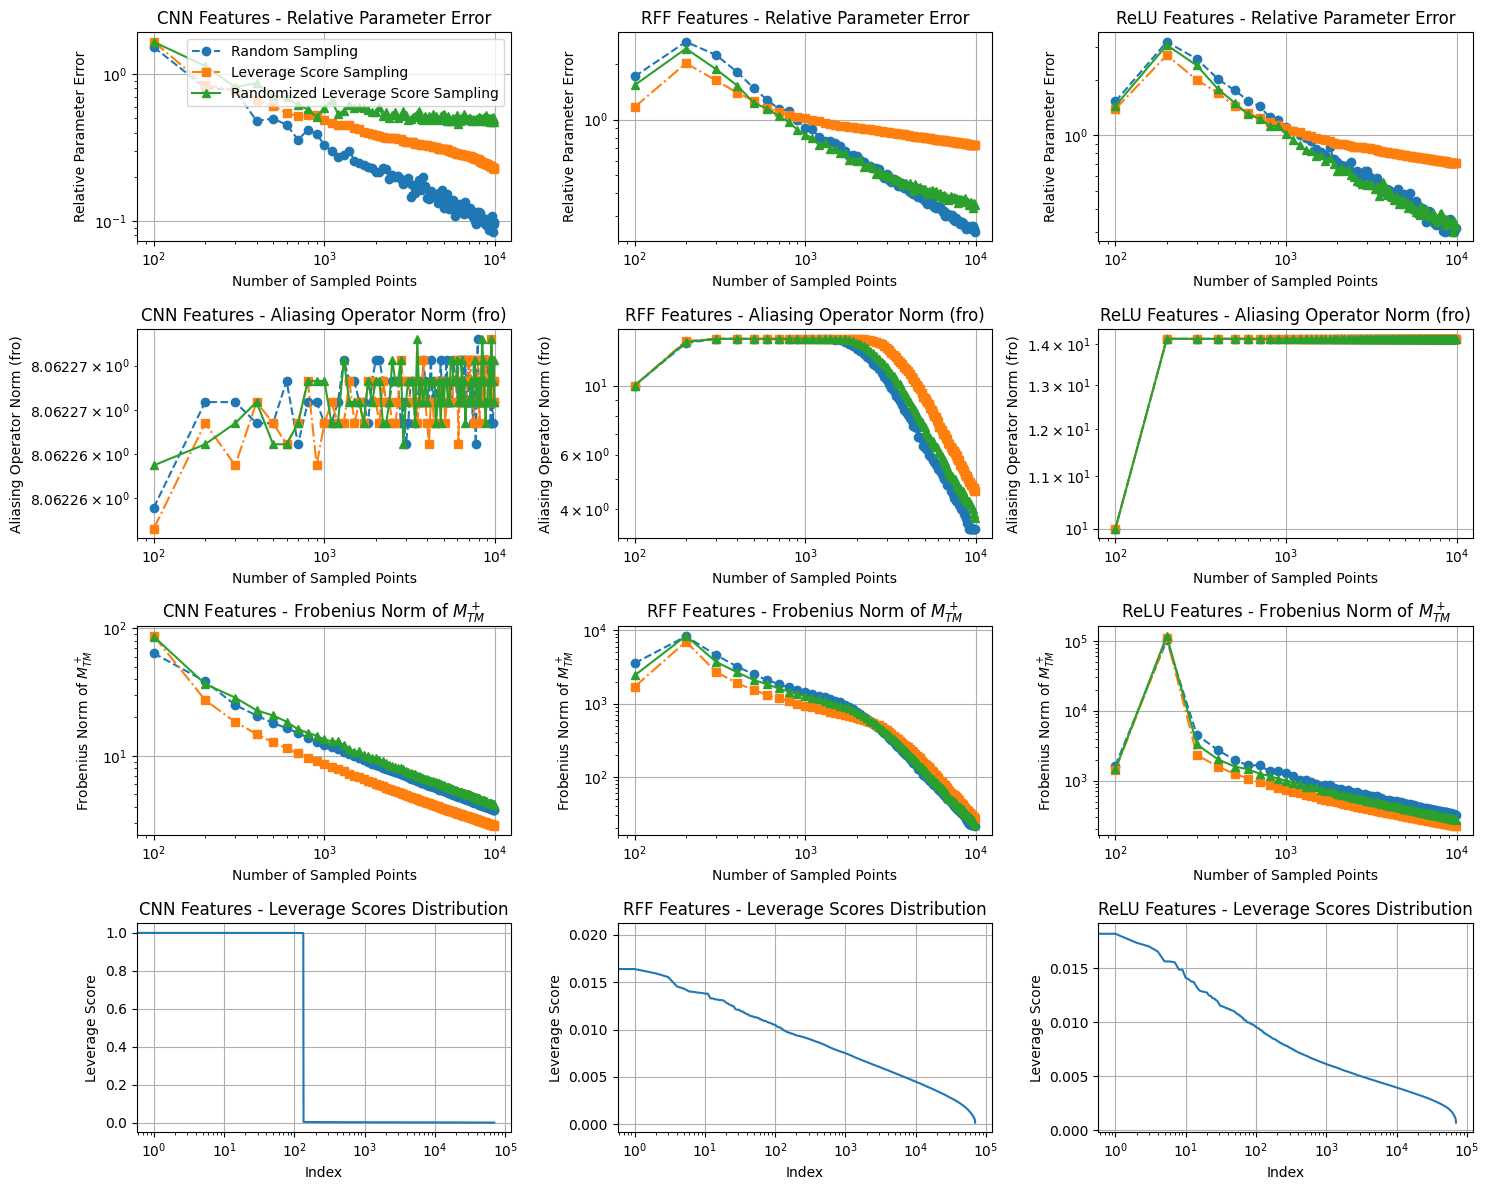

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot results in 4 by 3 grid (4 metrics, 3 datasets)
metrics = ["parameter_error", "aliasing_error", "norm_M_pinv"]
extra_metrics = ["Leverage Scores Distribution"]
datasets = {
    "CNN Features": (cnn_x_axis, cnn_data),
    "RFF Features": (rff_x_axis, rff_data),
    "ReLU Features": (relu_x_axis, relu_data),
}
methods = ["random", "leverage", "random_leverage"]
method_labels = {
    "random": "Random Sampling",
    "leverage": "Leverage Score Sampling",
    "random_leverage": "Randomized Leverage Score Sampling",
}
metric_labels = {
    "parameter_error": "Relative Parameter Error",
    "aliasing_error": "Aliasing Operator Norm (fro)",
    "norm_M_pinv": "Frobenius Norm of $M_{TM}^+$",
}
method_styles = {
    "random": "o--",
    "leverage": "s-.",
    "random_leverage": "^-",
}

fig, axes = plt.subplots(len(metrics) + len(extra_metrics), len(datasets), figsize=(15, 12))

print(cnn_data["parameter_error"]["random"])

for col, (dataset_name, (x_axis, data)) in enumerate(datasets.items()):
    for row, metric in enumerate(metrics):
        ax = axes[row, col]
        for method in methods:
            ax.plot(
                x_axis,
                [x.cpu().numpy() for x in data[metric][method]],
                method_styles[method],
                label=method_labels[method],
            )
        ax.set_title(f"{dataset_name} - {metric_labels[metric]}")
        ax.set_xlabel("Number of Sampled Points")
        ax.set_xscale("log")
        ax.set_ylabel(metric_labels[metric])
        ax.set_yscale("log")
        ax.grid(True)
        if row == 0 and col == 0:
            ax.legend()

    # Plot leverage scores distribution
    ax = axes[len(metrics), col]
    if dataset_name == "CNN Features":
        M = mnist_cnn_embedding.float()
    elif dataset_name == "RFF Features":
        M = mnist_rff_features.float()
    else:  # ReLU Features
        M = mnist_relu_features.float()

    leverage_scores = (
        torch.linalg.norm(torch.linalg.qr(M, mode="reduced").Q, dim=1) ** 2
    ).cpu().numpy()
    ax.plot(np.sort(leverage_scores)[::-1])
    ax.set_title(f"{dataset_name} - Leverage Scores Distribution")
    ax.set_xlabel("Index")
    ax.set_xscale("log")
    ax.set_ylabel("Leverage Score")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Plot leverage scores distribution to observe difference from uniform sampling

## CIFAR-10

The CIFAR-10 dataset consists of 60,000 images in color with a resolution of 32x32 pixels, divided into 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck). This gives us a 60,000 x 32 x 32 x 3 = 60,000 x 3072 data matrix.

In [ ]:
from torchvision.datasets import CIFAR10


trainset = CIFAR10(root='./data', train=True, download=True)
testset = CIFAR10(root='./data', train=False, download=True)


torch.Size([50000, 3072]) torch.Size([50000])
